# Importing Modules

In [1]:
!pip install geopy

In [2]:
import warnings, re,math, datetime, time
start_time = time.time()
from datetime import timedelta
warnings.filterwarnings("ignore")
import math
import pandas as pd
import csv, io
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import nltk, string
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import geopandas as gpd
from geopy import geocoders
gn = geocoders.GeoNames(username = "idselection")
import shapely
from shapely.geometry import Point, LineString, Polygon

In [3]:
#df = pd.read_csv(io.BytesIO(uploaded['Elections2019.csv']))
df = pd.read_csv("Elections2019.csv")
df.head()

,last_updated,tweet_id,created_at,user_location,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,District,Country
0,06-03-2019 17:30,1.100000e+18,06-03-2019 03:33,Guwahati,Guwahati has gained a lot of prominence in rec...,0.0,4.0,113.0,113,ActEast,narendramodi,Guwahati,Assam,NaN,India
1,17-03-2019 18:11,1.110000e+18,17-03-2019 17:27,NaN,RSS in school days itself? Indoctrinated since...,0.0,0.0,5.0,5,NaN,NaN,NaN,NaN,NaN,India
2,23-03-2019 18:07,1.110000e+18,23-03-2019 11:28,New Delhi,Words don't exist in Vaccum!\nModi's post Pulw...,0.0,4.0,31.0,31,NaN,NaN,New Delhi Municipal Council,Delhi,NaN,India
3,11-03-2019 17:47,1.100000e+18,26-02-2019 07:40,NaN,"India's #Icecream Industry stands at 15,000 cr...",0.0,0.0,3.0,3,Icecream,NaN,NaN,NaN,NaN,India
4,27-02-2019 18:18,1.100000e+18,27-02-2019 12:21,Delhi | Odisha,*40 CRPF Jawans killed in Pulwama Attack\n*IAF...,0.0,0.0,9.0,9,NaN,NaN,NaN,Delhi,NaN,India


# Loading Election Dataset

In [4]:
#df = pd.read_csv(io.BytesIO(uploaded['Elections2019.csv']))
df = pd.read_csv("Elections2019.csv")
df.head()

,last_updated,tweet_id,created_at,user_location,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,District,Country
0,06-03-2019 17:30,1.100000e+18,06-03-2019 03:33,Guwahati,Guwahati has gained a lot of prominence in rec...,0.0,4.0,113.0,113,ActEast,narendramodi,Guwahati,Assam,NaN,India
1,17-03-2019 18:11,1.110000e+18,17-03-2019 17:27,NaN,RSS in school days itself? Indoctrinated since...,0.0,0.0,5.0,5,NaN,NaN,NaN,NaN,NaN,India
2,23-03-2019 18:07,1.110000e+18,23-03-2019 11:28,New Delhi,Words don't exist in Vaccum!\nModi's post Pulw...,0.0,4.0,31.0,31,NaN,NaN,New Delhi Municipal Council,Delhi,NaN,India
3,11-03-2019 17:47,1.100000e+18,26-02-2019 07:40,NaN,"India's #Icecream Industry stands at 15,000 cr...",0.0,0.0,3.0,3,Icecream,NaN,NaN,NaN,NaN,India
4,27-02-2019 18:18,1.100000e+18,27-02-2019 12:21,Delhi | Odisha,*40 CRPF Jawans killed in Pulwama Attack\n*IAF...,0.0,0.0,9.0,9,NaN,NaN,NaN,Delhi,NaN,India


# Dimensions

In [5]:
df = df.drop(labels=range(0,46043//2), axis=0)
df.shape

(23022, 15)

# Displaying columns with NaN

In [6]:
df.isnull().sum()

last_updated                     1
tweet_id                         0
created_at                       1
user_location                 2890
full_text                        0
quote_count                    706
reply_count                    706
retweet_count                    2
favorite_count                   0
hashtags                     18519
user_mentions_screen_name    14147
City                         15144
State                        14379
District                     23021
Country                      10321
dtype: int64

# Attribute Data Types

In [7]:
df.dtypes

last_updated                  object
tweet_id                     float64
created_at                    object
user_location                 object
full_text                     object
quote_count                  float64
reply_count                  float64
retweet_count                float64
favorite_count                 int64
hashtags                      object
user_mentions_screen_name     object
City                          object
State                         object
District                     float64
Country                       object
dtype: object

# Dropping unnecessary rows and columns

### We drop user_location since they are redundant and aren't useful and district since 95% is NaN

In [8]:
df = df[pd.notnull(df['created_at'])]
df.dropna(subset=["full_text"], inplace = True)
df.drop("District", axis = 1, inplace =True)
df.drop("user_location", axis=1, inplace = True)
df.shape

(23021, 13)

# Removing US tweets

### The database also has US Congress tweets which must be removed

In [9]:
usa_terms = ["usa", "united states", "trump", "america", "democrat","cia", "fbi", "nsa"]
for i in range(0,46043):
    try:
        flag = True
        x = df.loc[i,"full_text"]
        #print(x)
        for j in usa_terms:
            if j in str(x).lower():
                flag = False
                break
        if flag==False:
            df = df.drop(i)
    except:
        pass
df = df[df["Country"] != "Others"]

In [10]:
df.shape

(19908, 13)

# Replacing NaN values

### All missing values are replaced with default twitter values

In [11]:
df["Country"].fillna("India", inplace=True)
df["retweet_count"].fillna(0, inplace=True)
df["quote_count"].fillna(0, inplace=True)
df["reply_count"].fillna(0, inplace=True)
df["favorite_count"].fillna(0, inplace=True)
df["State"].fillna("", inplace=True)
df["hashtags"].fillna("", inplace=True)
df["user_mentions_screen_name"].fillna("", inplace=True)
df["Country"]=df["Country"].replace("0","India") 
df["Country"]=df["Country"].replace("1","India")
df["Country"]=df["Country"].replace("2","India")
df["State"]=df["State"].replace("0","")
df["State"]=df["State"].replace("1","")
df["State"]=df["State"].replace("2","")
df["City"].fillna("", inplace=True) 

In [12]:
df.head()

,last_updated,tweet_id,created_at,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,Country
23021,25-03-2019 18:11,9.090000e+17,17-09-2017 03:45,#HappyBirthdayPM @narendramodi ji I pray for y...,0.0,0.0,2.0,2,"HappyBirthdayPM,NaMo",narendramodi,New Delhi Municipal Council,Delhi,India
23022,09-04-2019 17:36,1.120000e+18,08-04-2019 18:56,The responses to this RTI application regardin...,91.0,66.0,2151.0,2151,,,New Delhi Municipal Council,Delhi,India
23023,17-03-2019 17:32,1.110000e+18,17-03-2019 15:32,PM Modi: #ManoharParrikar was an unparalleled ...,15.0,32.0,1652.0,1652,ManoharParrikar,,,,India
23024,09-04-2019 17:35,1.120000e+18,09-04-2019 15:26,ZOA president Mort Klein is currently testifyi...,5.0,3.0,76.0,76,,,,,India
23025,18-02-2019 18:00,1.100000e+18,18-02-2019 13:26,@ashoswai @IndianExpress Absolutely right with...,0.0,0.0,7.0,7,,"ashoswai,IndianExpress",,,India


# Fixing Dates

In [13]:
lastupdate, created = [], []
for i in df["last_updated"]:
    lastupdate.append(datetime.datetime.strptime(i, "%d-%m-%Y %H:%M"))
for i in df["created_at"]:
    created.append(datetime.datetime.strptime(i, "%d-%m-%Y %H:%M"))

In [14]:
df["created_at"] = created
df["last_updated"] = lastupdate
df.drop(df[df['last_updated'] > datetime.datetime(2019,5,23,0,0)].index, inplace = True) 
df.drop(df[df['created_at'] > datetime.datetime(2019,5,23,0,0)].index, inplace = True) 

In [15]:
df.head()

,last_updated,tweet_id,created_at,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,Country
23021,2019-03-25 18:11:00,9.090000e+17,2017-09-17 03:45:00,#HappyBirthdayPM @narendramodi ji I pray for y...,0.0,0.0,2.0,2,"HappyBirthdayPM,NaMo",narendramodi,New Delhi Municipal Council,Delhi,India
23022,2019-04-09 17:36:00,1.120000e+18,2019-04-08 18:56:00,The responses to this RTI application regardin...,91.0,66.0,2151.0,2151,,,New Delhi Municipal Council,Delhi,India
23023,2019-03-17 17:32:00,1.110000e+18,2019-03-17 15:32:00,PM Modi: #ManoharParrikar was an unparalleled ...,15.0,32.0,1652.0,1652,ManoharParrikar,,,,India
23024,2019-04-09 17:35:00,1.120000e+18,2019-04-09 15:26:00,ZOA president Mort Klein is currently testifyi...,5.0,3.0,76.0,76,,,,,India
23025,2019-02-18 18:00:00,1.100000e+18,2019-02-18 13:26:00,@ashoswai @IndianExpress Absolutely right with...,0.0,0.0,7.0,7,,"ashoswai,IndianExpress",,,India


# Sorting Dataset by Dates

In [16]:
df = df.sort_values(by=['last_updated'])

In [17]:
df.head()

,last_updated,tweet_id,created_at,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,Country
34596,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,0.0,0.0,2.0,2,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India
30646,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,52.0,295.0,10761.0,10761,,narendramodi,,,India
31531,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",19.0,33.0,717.0,717,,manoharparrikar,New Delhi Municipal Council,Delhi,India
32798,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,1.0,12.0,513.0,513,,,Kolkata,West Bengal,India
36172,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,1.0,1.0,37.0,37,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India


# New Dimensions after dropping rows and columns

In [18]:
df.shape

(19908, 13)

# Showing NaN 

In [19]:
df.isnull().sum()

last_updated                 0
tweet_id                     0
created_at                   0
full_text                    0
quote_count                  0
reply_count                  0
retweet_count                0
favorite_count               0
hashtags                     0
user_mentions_screen_name    0
City                         0
State                        0
Country                      0
dtype: int64

# Mapping Cities and States

In [20]:
capitals = dict(zip(
    ['Delhi', 'Karnataka', 'Andhra Pradesh', 'Maharashtra',
       'Punjab', 'Uttar Pradesh', 'Gujarat', 'Pondicherry', 'Jharkhand',
       'Chandigarh', 'Madhya Pradesh', 'West Bengal', 'Assam',
       'Jammu & Kashmir', 'Bihar', 'Haryana', 'Tamil Nadu', 'Orissa',
       'Chhattisgarh', 'Rajasthan', 'Uttaranchal', 'Telangana',
       'Daman & Diu', 'Meghalaya', 'Tripura', 'Kerala', 'Goa',
       'Himachal Pradesh', 'Manipur', 'Arunachal Pradesh', 'Lakshadweep',
       'Andaman & Nicobar Islands', 'Mizoram', 'Nagaland', 'Sikkim'],
                    
    ['New Delhi','Bangalore','Hyderabad','Mumbai','Chandigarh','Lucknow', 'Gandhinagar', 'Pondicherry',"Ranchi","Chandigarh",
         "Bhopal", "Kolkata", "Dispur", "Srinagar", "Patna", "Chandigarh", "Chennai", "Bhubaneswar", "Raipur",
        "Jaipur", "Dehradun", "Hyderabad", "Daman", "Shillong", "Agartala", "Trivandrum", "Panaji", "Shimla",
        "Imphal", "Itanagar", "Kavaratti", "Port Blair", "Aizawl", "Kohima","Gangtok"]))

# Replacing NULL cities to state capitals

In [21]:
for i in range(0,19908):
    try:
        if df["City"][i]=='':
            df["City"][i] = capitals[df["State"][i]]
    except:
        pass
df.head()

,last_updated,tweet_id,created_at,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,Country
34596,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,0.0,0.0,2.0,2,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India
30646,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,52.0,295.0,10761.0,10761,,narendramodi,,,India
31531,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",19.0,33.0,717.0,717,,manoharparrikar,New Delhi Municipal Council,Delhi,India
32798,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,1.0,12.0,513.0,513,,,Kolkata,West Bengal,India
36172,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,1.0,1.0,37.0,37,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India


# Finding city name variations

In [22]:
d = {}
for i in df["City"]:
    #print("Checking for ",i)
    if i not in d:
        d[i]=set()
    for j in df["City"]:
        if(i in j and i!=''):
            d[i].add(j)
for i in d:
    if len(d[i])>1:
        print(i,d[i])

Hyderabad {'Hyderabad', 'Hyderabad M.Corp'}
Rewa {'Rewari', 'Rewa'}
Thane {'Kalambe Turf Thane', 'Thane'}
Nagar {'Nagar', 'Anand Nagar', 'S.A.S. Nagar (Mohali)', 'Jemari  (J.K. Nagar Township)'}
Jodhpur {'Jodhpur', 'Jam Jodhpur'}
Banga {'Bangalore', 'Banga'}
Bad {'Badgam', 'Bad'}
Lakhimpur {'North Lakhimpur', 'Lakhimpur'}
Durg {'Durgapur', 'Durg'}
Udaipur {'Udaipur', 'Chhota Udaipur'}


# Modifying variations of city names

In [29]:
df["City"]=df["City"].replace("Navi Mumbai","Mumbai")
df["City"]=df["City"].replace("Greater Mumbai","Mumbai")
df["City"]=df["City"].replace("Bokaro Steel City","Bokaro")
df["City"]=df["City"].replace("L.B. Nagar","Hyderabad")
df["City"]=df["City"].replace("Delhi Cantt.","New Delhi")
df["City"]=df["City"].replace("New Delhi Municipal Council","New Delhi")
df["City"]=df["City"].replace("Hyderabad M.Corp", "Hyderabad")
df["City"]=df["City"].replace("Tambaur-cum-Ahmadabad", "Ahmedabad")
df["City"]=df["City"].replace("Ahmedabad Cantonment", "Ahmedabad")
df["City"]=df["City"].replace('S.A.S. Nagar (Mohali)', "Mohali")
df["City"]=df["City"].replace('Panchkula Urban Estate', "Panchkula")
df["City"]=df["City"].replace('Mirzapur-cum-Vindhyachal', "Mirzapur")
df["City"]=df["City"].replace('Jawaharnagar (Gujarat Refinery)', "Jawaharnagar")
df["City"]=df["City"].replace('Jemari  (J.K. Nagar Township)', "Jemari")
df["City"]=df["City"].replace('Jam Jodhpur', "Jodhpur")
df["City"]=df["City"].replace('Bodh Gaya', "Gaya")
df["City"]=df["City"].replace('Chamoli Gopeshwar', "Gopeshwar")
df["City"]=df["City"].replace('English Bazar', "Malda")
df["City"]=df["City"].replace('G.C.F Jabalpur', "Jabalpur")
df["City"]=df["City"].replace('Ambikapur Part-X', "Ambikapur")
df["City"]=df["City"].replace('Azhikode South', "Azikode")
df["City"]=df["City"].replace('Bhagalpur (M.Corp)', "Bhagalpur")
df["City"]=df["City"].replace('Bad', "Badgam")
df["City"]=df["City"].replace('Badgam', "Budgam")
df["City"]=df["City"].replace('Nagar', "Anand Nagar")
df["City"]=df["City"].replace('Kalambe Turf Thane', "Thane")
df["City"]=df["City"].replace('Anand', "Anand Nagar")
df["City"]=df["City"].replace('North Lakhimpur', "Lakhimpur")
df["City"]=df["City"].replace('Chhota Udaipur', "Udaipur")
df["City"]=df["City"].replace('Balod', "Baloda")
df["City"]=df["City"].replace('Chandrapur Bagicha', "Chandrapur")

# Looking for City and State mistmatches

In [30]:
set(df["City"]).intersection(set(df["State"]))

{'', 'Bihar', 'Chandigarh', 'Pondicherry'}

# Setting columns with city as Bihar to Patna

In [31]:
for i in range(1,19908):
    try:
        if df["City"][i] == "Bihar":
            if df["City"][i] == "" or df["City"][i] not in capitals:
                df["City"][i] = "Patna"
                df["State"][i] = "Bihar"
            else:
                df["City"][i] = capitals[df["State"][i]]
    except:
        pass

# Resetting index values

In [32]:
df = df.reset_index()
df.drop("index", axis=1, inplace = True)

# Final Cleaned Dataset

In [33]:
df

,last_updated,tweet_id,created_at,full_text,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,Country
0,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,0.0,0.0,2.0,2,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India
1,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,52.0,295.0,10761.0,10761,,narendramodi,,,India
2,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",19.0,33.0,717.0,717,,manoharparrikar,New Delhi,Delhi,India
3,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,1.0,12.0,513.0,513,,,Kolkata,West Bengal,India
4,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,1.0,1.0,37.0,37,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19903,2019-05-16 18:28:00,1.130000e+18,2019-05-16 18:18:00,Fashion nieuws: Whoa! Deepika Padukone Served ...,0.0,0.0,3.0,3,,,,,India
19904,2019-05-16 18:28:00,1.130000e+18,2019-05-16 13:47:00,@OmarAbdullah Absolutely NOT. \nHe was a Natio...,1.0,18.0,280.0,280,,OmarAbdullah,,,India
19905,2019-05-16 18:29:00,1.130000e+18,2019-05-16 14:55:00,A web page dedicated to tracking Rahul Gandhi'...,0.0,1.0,18.0,18,,,,,India
19906,2019-05-16 18:29:00,1.130000e+18,2019-05-16 09:41:00,This is the real reason that Modi-Shah duo hav...,50.0,192.0,340.0,340,,IndiaToday,,,India


# Final Dimensions

In [34]:
df.shape

(19908, 13)

# Inititalising Vectorizer, Sentiment Analyser and Stemmer

In [35]:
import nltk
"""nltk.download("vader_lexicon")
nltk.download("stopwords")"""
stemmer = SnowballStemmer('english')
vectorizer = TfidfVectorizer(use_idf = True, tokenizer = nltk.word_tokenize,stop_words='english', smooth_idf = True)
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
sid = SentimentIntensityAnalyzer()
stopw = set(stopwords.words('english'))

In [36]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to C:\Users\DELL-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\DELL-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Text Preprocessing Unit

In [37]:
contraction = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have", "bharatiya janata party" : "bjp",
                   "inc" : "congress","@narendramodi":"modi", "pappu":"rahul gandhi","gandhi":"rahul gandhi", "@rahulgandhi":"Rahul Gandhi"}

def clean(text):
    text = text.lower()
    temp = ""
    for i in text.split():
        if i not in stopw:
            try:
                temp+=contraction[i]+' '
            except:
                temp+= i+' '
    text = temp.strip()
    text = re.sub(r'http\S+','', text)
    text = text.lower().translate(remove_punctuation_map)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace("bhartiya janata party",'bjp')
    text = text.replace("indian national congress", 'congress')
    text = text.replace("aam aadmi party", 'aap')
    text = text.replace("narendra modi", 'modi')
    text = text.replace("rahulgandhi", 'rahul gandhi')
    temp=''
    for i in text:
        if i.isdigit()==False:
            temp+=i
    text = temp
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text.strip()

# Cosine Similarity Function

In [38]:
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1.strip(), text2.strip()])
    return ((tfidf * tfidf.T))[0,1]

# Preprocessing Tweets

In [39]:
preprocessed = []
for i in df["full_text"]:
    preprocessed.append(clean(i.strip().lower()))
preprocessed

['inclusivemind ark bjpindia rahul gandhi bjp think cellchatumediacroniesscrit writer andbhakt crore speach give victori then late atal bihari vajpeyi much better shine india',
 'prime minist shri modi today expos congress parti s fals fake campaign sever issu deliv outstand speech floor lok sabha congratul prime minist complet demolish opposit s claim',
 'rahul rahul gandhi ji use claim defenc minist manoharparrikar ji complet ignor rafaled note rafal file anoth lie expos rahulliecaught',
 'bjp win battl past month bengal pm modi arriv win biggest battl announc warcri upcom war tmc elect modisonarbangla',
 'rafalescam saugataroymp loksabha today modishah duo destroy defenc backbon countri',
 'stori realli expos develop propaganda nation congress cudnt yrs modi sirji ask month abl hear terrifi stori jharkhand govt cudnt even solv basic issu last yrs',
 'senior congress leader manishtewari jpc definit next parliament parallel crimin investig process go go away rafal rafalenot',
 'jim jo

# Inserting Processed Tweets

In [40]:
df.insert(4,"processed_tweet",preprocessed,True)
df.head()

,last_updated,tweet_id,created_at,full_text,processed_tweet,quote_count,reply_count,retweet_count,favorite_count,hashtags,user_mentions_screen_name,City,State,Country
0,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,inclusivemind ark bjpindia rahul gandhi bjp th...,0.0,0.0,2.0,2,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India
1,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,prime minist shri modi today expos congress pa...,52.0,295.0,10761.0,10761,,narendramodi,,,India
2,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",rahul rahul gandhi ji use claim defenc minist ...,19.0,33.0,717.0,717,,manoharparrikar,New Delhi,Delhi,India
3,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,bjp win battl past month bengal pm modi arriv ...,1.0,12.0,513.0,513,,,Kolkata,West Bengal,India
4,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,rafalescam saugataroymp loksabha today modisha...,1.0,1.0,37.0,37,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India


# Finding most tagged twitter handles

In [41]:
df["user_mentions_screen_name"].value_counts()[:9]

                        12525
narendramodi              657
RahulGandhi               332
INCIndia                  199
BJP4India                  81
ANI                        62
AmitShah                   55
INCIndia,RahulGandhi       49
ArvindKejriwal             46
Name: user_mentions_screen_name, dtype: int64

# Processing Sentiment Scores

In [42]:
sentiment = {"Positive":[], "Negative" :[], "Neutral":[], "Compound":[]}
for i in df["processed_tweet"]:
    sentiment["Positive"].append(sid.polarity_scores(i)['pos'])
    sentiment["Negative"].append(sid.polarity_scores(i)['neg'])
    sentiment["Neutral"].append(sid.polarity_scores(i)['neu'])
    sentiment["Compound"].append(sid.polarity_scores(i)['compound'])

In [43]:
df.insert(9,"Neutral",sentiment['Neutral'],True)
df.insert(10,"Positive",sentiment['Positive'],True)
df.insert(11,"Negative",sentiment['Negative'],True)
df.insert(12,"Compound",sentiment['Compound'],True)

In [44]:
df.shape

(19908, 18)

# Summarising RT's, Quotes and Replies

In [45]:
df.loc[:,"quote_count":"retweet_count"].describe()

,quote_count,reply_count,retweet_count
count,19908.000000,19908.000000,19908.000000
mean,10.285915,30.234479,438.239100
std,92.679294,247.224128,2732.813373
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000
50%,0.000000,1.000000,17.000000
75%,2.000000,7.000000,133.000000
max,6665.000000,14582.000000,206958.000000


# Analysing Tweet Importance

In [46]:
imp = []
for i in range(0,19908):
    if df["retweet_count"][i]>=70 or sum([df["retweet_count"][i],df["quote_count"][i],df["reply_count"][i]])>=50:
        imp.append(1)
    else:
        imp.append(0)

In [47]:
df.insert(8,"Importance",imp,True)
df.head()

,last_updated,tweet_id,created_at,full_text,processed_tweet,quote_count,reply_count,retweet_count,Importance,favorite_count,Neutral,Positive,Negative,Compound,hashtags,user_mentions_screen_name,City,State,Country
0,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,inclusivemind ark bjpindia rahul gandhi bjp th...,0.0,0.0,2.0,0,2,0.884,0.116,0.000,0.4404,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India
1,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,prime minist shri modi today expos congress pa...,52.0,295.0,10761.0,1,10761,0.890,0.000,0.110,-0.4767,,narendramodi,,,India
2,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",rahul rahul gandhi ji use claim defenc minist ...,19.0,33.0,717.0,1,717,1.000,0.000,0.000,0.0000,,manoharparrikar,New Delhi,Delhi,India
3,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,bjp win battl past month bengal pm modi arriv ...,1.0,12.0,513.0,1,513,0.582,0.276,0.142,0.5719,,,Kolkata,West Bengal,India
4,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,rafalescam saugataroymp loksabha today modisha...,1.0,1.0,37.0,0,37,0.720,0.000,0.280,-0.5423,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India


In [48]:
df["Importance"].value_counts()

0    12267
1     7641
Name: Importance, dtype: int64

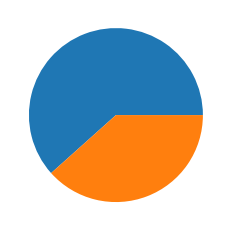

In [49]:
plt.pie(df["Importance"].value_counts())
plt.show()

In [50]:
dfcorr = df.corr(method="pearson")

In [51]:
dfcorr

,tweet_id,quote_count,reply_count,retweet_count,Importance,favorite_count,Neutral,Positive,Negative,Compound
tweet_id,1.000000,-0.082323,-0.031576,-0.034986,-0.003206,-0.034986,0.002718,0.003923,-0.007277,0.005325
quote_count,-0.082323,1.000000,0.803824,0.758241,0.137232,0.758241,-0.013934,0.007190,0.010781,-0.004498
reply_count,-0.031576,0.803824,1.000000,0.744032,0.151375,0.744032,-0.015372,0.010429,0.009455,-0.002394
retweet_count,-0.034986,0.758241,0.744032,1.000000,0.199140,1.000000,-0.018725,0.024677,-0.000094,0.016636
Importance,-0.003206,0.137232,0.151375,0.199140,1.000000,0.199140,-0.019860,0.007542,0.018004,-0.006088
favorite_count,-0.034986,0.758241,0.744032,1.000000,0.199140,1.000000,-0.018725,0.024677,-0.000094,0.016636
Neutral,0.002718,-0.013934,-0.015372,-0.018725,-0.019860,-0.018725,1.000000,-0.633727,-0.659138,0.062757
Positive,0.003923,0.007190,0.010429,0.024677,0.007542,0.024677,-0.633727,1.000000,-0.164015,0.668816
Negative,-0.007277,0.010781,0.009455,-0.000094,0.018004,-0.000094,-0.659138,-0.164015,1.000000,-0.730226
Compound,0.005325,-0.004498,-0.002394,0.016636,-0.006088,0.016636,0.062757,0.668816,-0.730226,1.000000


# Setting up Scoring Function

In [52]:
m11 = dfcorr["Compound"]["quote_count"]
m22 = dfcorr["Compound"]["reply_count"]
m33 = dfcorr["Compound"]["retweet_count"]
m44 = dfcorr["Compound"]["favorite_count"]
m55 = dfcorr["Compound"]["Importance"]

#Positive or compound?

m1 = dfcorr["Positive"]["quote_count"]
m2 = dfcorr["Positive"]["reply_count"]
m3 = dfcorr["Positive"]["retweet_count"]
m4 = dfcorr["Positive"]["favorite_count"]
m5 = dfcorr["Positive"]["Importance"]

In [53]:
score = lambda x1,x2,x3,x4,x5: m1*x1+m2*x2+m3*x3+m4*x4+x5
#score1 = lambda x1,x2,x3,x4,x5: m11*x1+m22*x2+m33*x3+m44*x4+x5

In [54]:
#Random test case
score(10,20,30,10,0)

1.2675376491631405

In [55]:
score(10,20,30,10,1) 

2.2675376491631405

# Scoring Tweets

In [56]:
scores = []
for i in range(0,19908):
    qt = df["quote_count"][i]
    reply = df["reply_count"][i]
    rt = df["retweet_count"][i]
    fav = df["favorite_count"][i]
    imp = df["Importance"][i]
    scores.append(score(qt,reply,rt,fav,imp))

In [57]:
df["Score"] = scores

In [58]:
df.head()

,last_updated,tweet_id,created_at,full_text,processed_tweet,quote_count,reply_count,retweet_count,Importance,favorite_count,Neutral,Positive,Negative,Compound,hashtags,user_mentions_screen_name,City,State,Country,Score
0,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,inclusivemind ark bjpindia rahul gandhi bjp th...,0.0,0.0,2.0,0,2,0.884,0.116,0.000,0.4404,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India,0.098706
1,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,prime minist shri modi today expos congress pa...,52.0,295.0,10761.0,1,10761,0.890,0.000,0.110,-0.4767,,narendramodi,,,India,535.539260
2,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",rahul rahul gandhi ji use claim defenc minist ...,19.0,33.0,717.0,1,717,1.000,0.000,0.000,0.0000,,manoharparrikar,New Delhi,Delhi,India,36.866941
3,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,bjp win battl past month bengal pm modi arriv ...,1.0,12.0,513.0,1,513,0.582,0.276,0.142,0.5719,,,Kolkata,West Bengal,India,26.450484
4,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,rafalescam saugataroymp loksabha today modisha...,1.0,1.0,37.0,0,37,0.720,0.000,0.280,-0.5423,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India,1.843684


# Classifying Tweets - Testing K-Means

In [59]:
X = vectorizer.fit_transform(df["processed_tweet"])
k =3
model = KMeans(n_clusters=2, init='k-means++', max_iter=100)
model.fit(X)

KMeans(max_iter=100, n_clusters=2)

In [60]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\DELL-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Cluster 0:
 modi
 congress
 bjp
 india
 amp
 pm
 vote
 s
 elect
 peopl
Cluster 1:
 rahul
 gandhi
 congress
 incindia
 modi
 presid
 amp
 india
 pm
 ji


# Testing Cosine Similarity

In [63]:
compare = ["bjp modi chowkidar rss",
          "congress rahul gandhi sonia pappu"]
party1 = []
for tweet in df["processed_tweet"]:
    sim = []
    sim.append([cosine_sim(compare[0],tweet),"BJP"])
    sim.append([cosine_sim(compare[1],tweet),"Congress"])
    sim.sort(key = lambda x: x[0],reverse = True)
    max_sim = sim[0][0]
    max_party = sim[0][1]
    if max_sim>0.2:
        party1.append(max_party)
    else:
        party1.append("Other")

In [64]:
party1

['Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress',
 'Other',
 'Congress',
 'Other',
 'BJP',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Congress'

# Testing Frequency Classification

In [65]:
compare = ["vijay rajnath ravishankar  yudhvirsethi patra narendra modi vijayvargiyah sadhvi bjp arun manoj reddy sushma rsprasad taneja maneka udhavthackeray gautam gambhir piyush goyal nitin gadkari gadkariji rss singh vasundhraraje bjpbengal smriti kailash gautamgambhir swamy udhav sushmaswaraj sadhvi pragya vasundhra sambitpatra shivraj arunjaitley manohar parikar subramanianswamy naredra modi manojtiwari amit modiji yogi adityanath sushma swaraj nitin vivekreddy shivrajsinghchouhan vijayrupani amit shah narendramodi pragya arun jaitley thackeray sunny deol bharatiya janata party kailashvijayvargiyah adityanath yogi jaitley piyush gadkari sambit smritiirani rajnathsingh irani swaraj gautam parikar nirmala bhartiya janta party ram nirmala sitaraman modi shivrajsingh nititngadkari manohar rammadhav smriti irani yedyurappa madhav gambhir narendra rajnath singh subrmanian goyal chouhan amitshah sitaraman manoharparikar ravishankar prasad rupani rao shah ravishankarprasad narsimha vivek vijay rupani prasad bhartiya janata party giriraj chowkidar",
          "congress rahul gandhi sonia pappu manish tiwari mani shankar aiyar amrinder singh navjot sidhu pilot sachin jyotiraditya scindia ashok gehlot ajay makhan makhen chidambaram raj babbar sheila dikshit kamal nath digvijay singh sanjay kaul ashok chavan prithviraj randeep surjaewala hooda deepender kapil sibal manmohan ahmed patil natwar gaurav vallabh pawan khera taneja reddy george antony venugopal rao raman gogoi lalu prasad yadav akhilesh ravat urmila milind deora siddaramiah shivkumar dks sandeep ashok tanwar prakash jha"]
documents = df["processed_tweet"]
party = []
for i in documents:
    l = len(i.split())
    freq_bjp = 0
    freq_cong = 0
    for j in compare[0].split():
        freq_bjp+=i.count(j.strip())
    for j in compare[1].split():
        freq_cong+=i.count(j.strip())
    #print(freq_cong, freq_bjp)
    if freq_bjp>freq_cong:
        party.append("BJP")
    elif freq_cong>freq_bjp:
        party.append("Congress")
    else:
        party.append("Other")

# Checking Party Counts

In [66]:
party.count("Other")

1827

In [67]:
party.count("BJP")


11064

In [68]:
party.count("Congress")

7017

# Inserting Party Attribute

In [193]:
df.insert(5,"Party",party)

In [194]:
df.head()

,last_updated,tweet_id,created_at,full_text,processed_tweet,Party,quote_count,reply_count,retweet_count,Importance,...,Neutral,Positive,Negative,Compound,hashtags,user_mentions_screen_name,City,State,Country,Score
0,2019-02-08 17:30:00,1.090000e+18,2019-02-08 17:29:00,@inclusivemind2 @Ark82876233 @BJP4India @Rahul...,inclusivemind ark bjpindia rahul gandhi bjp th...,Other,0.0,0.0,2.0,0,...,0.884,0.116,0.000,0.4404,,"inclusivemind2,Ark82876233,BJP4India,RahulGandhi",Aligarh,Uttar Pradesh,India,0.098706
1,2019-02-08 17:30:00,1.090000e+18,2019-02-07 16:14:00,Prime Minister Shri @narendramodi today expose...,prime minist shri modi today expos congress pa...,BJP,52.0,295.0,10761.0,1,...,0.890,0.000,0.110,-0.4767,,narendramodi,,,India,535.539260
2,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:09:00,"Rahul Gandhi ji, you used to claim that defenc...",rahul rahul gandhi ji use claim defenc minist ...,Congress,19.0,33.0,717.0,1,...,1.000,0.000,0.000,0.0000,,manoharparrikar,New Delhi,Delhi,India,36.866941
3,2019-02-08 17:30:00,1.090000e+18,2019-02-08 10:18:00,BJP has been winning battles over the past mon...,bjp win battl past month bengal pm modi arriv ...,BJP,1.0,12.0,513.0,1,...,0.582,0.276,0.142,0.5719,,,Kolkata,West Bengal,India,26.450484
4,2019-02-08 17:30:00,1.090000e+18,2019-02-08 08:07:00,#RafaleScam @SaugataRoyMP in #LokSabha today: ...,rafalescam saugataroymp loksabha today modisha...,BJP,1.0,1.0,37.0,0,...,0.720,0.000,0.280,-0.5423,"RafaleScam,LokSabha",SaugataRoyMP,Kolkata,West Bengal,India,1.843684


In [195]:
df["Party"].value_counts()

BJP         11064
Congress     7017
Other        1827
Name: Party, dtype: int64

In [196]:
df.to_csv('new_election.csv')